### Imports

In [1]:
# Tratamiento de datos
# ==============================================================================
from sklearn import datasets
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.model_selection import ValidationCurveDisplay, validation_curve

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

### Funciones Auxiliares

In [2]:
def metricas(y_test, y_test_pred, y_train, y_train_pred, modelo):
   
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='macro')
    recall_test = recall_score(y_test, y_test_pred, average='macro')
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    kappa_test = cohen_kappa_score(y_test, y_test_pred)

    # para el train
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred, average='macro')
    recall_train = recall_score(y_train, y_train_pred, average='macro')
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    kappa_train = cohen_kappa_score(y_train, y_train_pred)
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["validation", "train"]})
    
    df["modelo"] = modelo
    return df

## 1. Lectura del conjunto de datos

In [3]:
iris = datasets.load_iris(as_frame=True)
df = iris.frame
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 2. Exploración y preprocesado

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [5]:
df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

### 2.1. Exploración

#### 2.1.1. Variable respuesta

In [6]:
df.value_counts("target")

target
0    50
1    50
2    50
Name: count, dtype: int64

## 3. División del conjunto de datos

In [7]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df["target"])

In [8]:
X_train = train_set.drop("target", axis=1)
y_train = train_set["target"]
X_test = test_set.drop("target", axis=1)
y_test = test_set["target"]

## 5. Entrenamiento del algoritmo

In [105]:
# Entrenamos el algoritmo

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

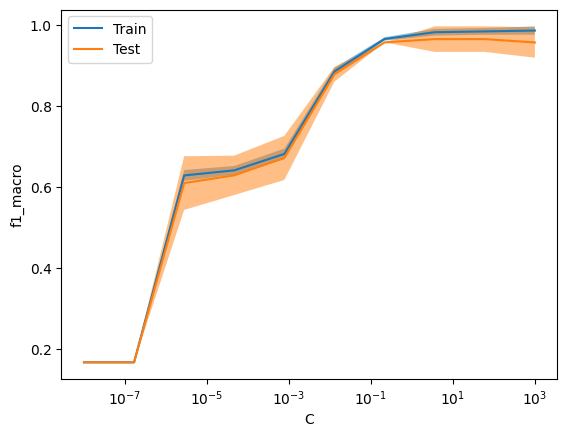

In [106]:
# Buscamos el hiperparámetro C que maximice f1_score

scoring = "f1_macro"
cv = StratifiedKFold()
param_range = np.logspace(-8, 3, 10)
train_scores, test_scores = validation_curve(clf, X_train, y_train, param_name="C", cv=cv, param_range=param_range, scoring=scoring)
display =ValidationCurveDisplay(param_name="C", param_range=param_range, train_scores=train_scores, test_scores=test_scores,
                                score_name=scoring)
display.plot()
plt.show()

In [107]:
# Usamos GridSearch para encontrar el máximo C

cv = KFold(n_splits=5)
C_values = np.arange(1, 10, 0.01)
param_grid = {"C" : C_values}
clf_best = GridSearchCV(clf, param_grid=param_grid, cv = cv, scoring='f1_macro')
clf_best.fit(X_train, y_train)
clf_best.best_estimator_

LogisticRegression(C=2.080000000000001)

In [112]:
# Creamos el clasificador óptimo

clf_tuned = LogisticRegression(C=2.08)
clf_tuned.fit(X_train, y_train)

LogisticRegression(C=2.08)

## 6. Evaluación del modelo

In [113]:
# Evaluamos el modelo en distintos folds para comprobar que se comporta correctamente en distintos subconjuntos de datos
# Vemos que no hay problemas de generalización.

cv = KFold(n_splits=5)
cross_validate(clf_tuned, X_train, y_train, cv=cv, return_train_score=True, 
               scoring=["accuracy", "recall_macro", "precision_macro", "f1_macro"])

{'fit_time': array([0.00752974, 0.00674272, 0.00468969, 0.00099897, 0.00686932]),
 'score_time': array([0.00590563, 0.0033648 , 0.00360298, 0.00480938, 0.00333977]),
 'test_accuracy': array([0.95833333, 0.95833333, 0.95833333, 1.        , 1.        ]),
 'train_accuracy': array([0.98958333, 0.98958333, 0.98958333, 0.96875   , 0.97916667]),
 'test_recall_macro': array([0.96296296, 0.95238095, 0.95833333, 1.        , 1.        ]),
 'train_recall_macro': array([0.98958333, 0.98989899, 0.98958333, 0.96868687, 0.97777778]),
 'test_precision_macro': array([0.96296296, 0.96296296, 0.95833333, 1.        , 1.        ]),
 'train_precision_macro': array([0.98958333, 0.98989899, 0.99019608, 0.96807796, 0.98148148]),
 'test_f1_macro': array([0.96078431, 0.95475113, 0.95555556, 1.        , 1.        ]),
 'train_f1_macro': array([0.98941799, 0.98974359, 0.98973387, 0.96822194, 0.97898194])}

## 7. Predicciones

In [114]:
# Hacemos predicciones en el conjunto de datos de entrenamiento y en el conjunto de datos
# que todavía no ha visto el modelo (X_test)

y_train_pred = clf_tuned.predict(X_train)
y_test_pred = clf_tuned.predict(X_test)

## 8. Evaluación de resultados

In [115]:
# Evaluamos las predicciones tanto en el test como en el train para comprobar con los
# nuevos datos posible overfitting o underfitting.

df_metricas = metricas(y_test, y_test_pred, y_train, y_train_pred, "Regresión Logística")
df_metricas

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.966667,0.969697,0.966667,0.966583,0.950,validation,Regresión Logística
1,0.983333,0.984127,0.983333,0.983323,0.975,train,Regresión Logística


In [124]:
y_test_proba = clf_tuned.predict_proba(X_test)

In [122]:
roc_auc_score(y_test, y_test_proba, multi_class="ovo")

1.0

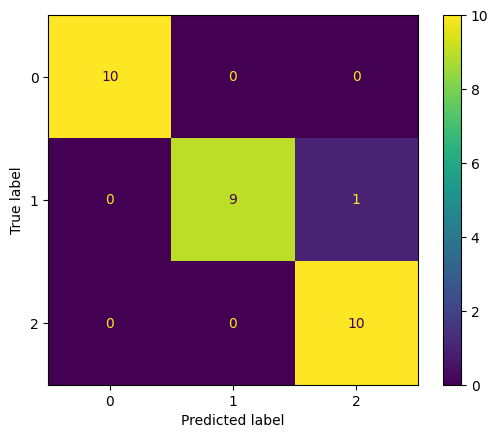

In [125]:
ConfusionMatrixDisplay.from_estimator(clf_tuned, X_test, y_test)